<a href="https://colab.research.google.com/github/aplneto/IF998/blob/main/02_Multi_armed_bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problema estacionário

In [1]:
%%writefile MultiArmedBandit.py
from numpy.random import binomial, uniform

class MultiArmedBandit(object):
  def __init__(self, n=10, **kwargs):
    probs = kwargs.get('prob', None)
    if probs is None:
      probs = [uniform(0.1, 0.9) for _ in range(n)]
    self.__probs = probs
  
  def play(self, n=0):
    if n >= len(self.__probs):
      raise ValueError('n deve estar entre 0 e %i' % len(self.__probs))
    return binomial(1, self.__probs[n])
  
  @property
  def probs(self):
    return self.__probs
  
  @property
  def optimal(self):
    return max(range(len(self.__probs)), key=lambda a: self.__probs[a])

Writing MultiArmedBandit.py


Função de valor estimada a partir da média dos retornos:

$
\begin{equation}
Q_{n+1}=Q_{n}+[\frac{1}{n}(R_n-Q_n)]
\end{equation}
$

## A simple bandit algorithm

$
\begin{equation}
  \text{Initialize, for } a = 1 \text{ to } k\\
  Q(a)\gets0\\
  N(a)\gets0\\
  \text{Repeat forever:}\\
A\gets
  \begin{cases}
  argmax_aQ(a)\text{ with probability 1-ϵ (breaking ties randomly)}
  \\\\
  a \text{ random action with probability ϵ}
  \end{cases}\\
  R\gets bandit(A)\\
  N(A)\gets N(A) + 1\\
  Q(A)\gets Q(A) + \frac{1}{N(A)}[R-Q(A)]
\end{equation}
$

In [2]:
from MultiArmedBandit import MultiArmedBandit

k = 10
epsilon = 0.1

bandits = MultiArmedBandit(k)

In [3]:
from threading import Thread
from time import sleep

forever = True

def stop_experiment(time=60):
  '''
  função auxiliar usada pra parar o experimento
  '''
  global forever
  sleep(time)
  forever = False

controller = Thread(target=stop_experiment, args=(60,))
controller.start()

In [4]:
from numpy.random import choice

Q = [0 for _ in range(k)]
N = [0 for _ in range(k)]

while forever:
  greedy = choice([0, 1], p=[epsilon, 1-epsilon])
  A = (
      max(range(len(Q)), key=lambda a: Q[a]) if greedy
      else choice(range(len(Q)))
  )
  R = bandits.play(A)
  N[A] = N[A] + 1
  Q[A] = Q[A] + (1/N[A])*(R - Q[A])

In [5]:
print(Q)
print(bandits.probs)

[0.11448417802932874, 0.5871313672922271, 0.8747876303622899, 0.38920676202860716, 0.7719727190837737, 0.26291441788743275, 0.5188604589817967, 0.7141930461857832, 0.864909553887364, 0.10435347628330091]
[0.11422264721094555, 0.5910450106445766, 0.8749349394885053, 0.3856825700221834, 0.7791641723789143, 0.2617235404161227, 0.5127884112537656, 0.7259271606800887, 0.8644233212256461, 0.10899068597258053]


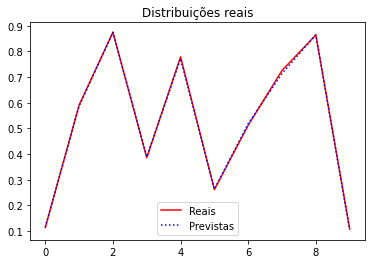

In [6]:
%matplotlib inline
from matplotlib import pyplot

# distribuições reais

ax1 = pyplot.subplot()
ax1.plot(bandits.probs, 'r-', label='Reais')
ax1.plot(Q, 'b:', label='Previstas')
ax1.set_title("Distribuições reais")
ax1.legend()


f = pyplot.plot()

## Problema não estacionários

$
\begin{equation}
Q_{n+1}=Q_n+\alpha\left[R_n-Q_n\right]\\
\end{equation}
\text{onde α é uma constante entre (0, 1] (leraning rate ou stepsize)}
$

* Esta opção dá mais relevância a estimativas mais recentes, enquanto estimativas antigas vão perdendo relevância com o tempo.
* Com o $\alpha$ sendo uma constante, não há convergência exata da função, mas ela consegue seguir mudanças nos ambientes não estacionários

[Bernoulli bandit](https://gdmarmerola.github.io/ts-for-bernoulli-bandit/)

## Exploration vs. Exploitation

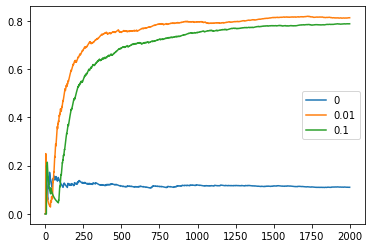

In [7]:
idx = 0

for ep in [0, 0.01, 0.1]:
  Q = [0 for _ in range(k)]
  N = [0 for _ in range(k)]

  # Recompensa total
  G = 0
  # Recompensas médias
  avg_rw = []

  i = 0
  while i < 2000:
    greedy = choice([0, 1], p=[ep, 1-ep])
    A = (
        max(range(len(Q)), key=lambda a: Q[a]) if greedy
        else choice(range(len(Q)))
    )
    R = bandits.play(A)
    G = G + R
    N[A] = N[A] + 1
    Q[A] = Q[A] + (1/N[A])*(R - Q[A])
    i += 1
    avg_rw.append(G/sum(N))
  
  pyplot.plot(avg_rw, label=str(ep))

pyplot.legend()
f = pyplot.plot()

## Convergência da Estimativa

$
\begin{equation}
\sum^{\infty}_{n=1}\alpha_n(a)=\infty\text{, garante que a função saia de qualquer condição inicial ruim}\\
\sum^{\infty}_{n=1}\alpha^2(a)\le\infty\text{, garane que a função irá convergir}
\end{equation}
$

## Valores iniciais otimistas

$
\begin{equation}
  \text{Initialize, for } a = 1 \text{ to } k\\
  Q(a)\gets5\\
  N(a)\gets0\\
  \text{Repeat forever:}\\
A\gets
  \begin{cases}
  argmax_aQ(a)\text{ with probability 1-ϵ (breaking ties randomly)}
  \\\\
  a \text{ random action with probability ϵ}
  \end{cases}\\
  R\gets bandit(A)\\
  N(A)\gets N(A) + 1\\
  Q(A)\gets Q(A) + \frac{1}{N(A)}[R-Q(A)]
\end{equation}
$

In [8]:
greedy_count = 0
greedy_avg = []

Q = [0 for _ in range(k)]
N = [0 for _ in range(k)]

i= 0
while i < 1000:
  greedy = choice([0, 1], p=[epsilon, 1-epsilon])
  if greedy:
    greedy_count += 1
  A = (
      max(range(len(Q)), key=lambda a: Q[a]) if greedy
      else choice(range(len(Q)))
  )
  R = bandits.play(A)
  N[A] = N[A] + 1
  Q[A] = Q[A] + (1/N[A])*(R - Q[A])
  greedy_avg.append(greedy_count/sum(N))
  i += 1

In [9]:
greedy_count = 0
greedy_avg_optimistic = []

Q = [5 for _ in range(k)]
N = [0 for _ in range(k)]

i= 0
while i < 1000:
  greedy = choice([0, 1], p=[epsilon, 1-epsilon])
  if greedy:
    greedy_count += 1
  A = (
      max(range(len(Q)), key=lambda a: Q[a]) if greedy
      else choice(range(len(Q)))
  )
  R = bandits.play(A)
  N[A] = N[A] + 1
  Q[A] = Q[A] + (1/N[A])*(R - Q[A])
  greedy_avg_optimistic.append(greedy_count/sum(N))
  i += 1

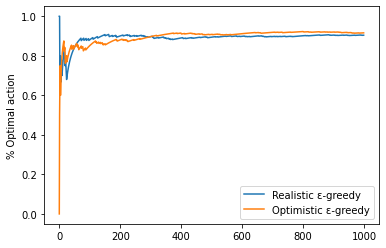

In [10]:
pyplot.plot(greedy_avg, label='Realistic \u03b5-greedy')
pyplot.plot(greedy_avg_optimistic, label='Optimistic \u03b5-greedy')
pyplot.legend()
pyplot.ylabel('% Optimal action')
f = pyplot.plot()

## [Upper Confidence Bound][UCB] (UCB)
* UCB estima o limite superior do valor de cada ação e reduz de maneira inteligente a exploração conforme passa o tempo
* Seleciona ações com o maior limite superior (estimado)
* UCB:

  $\\
\begin{align}
A_t≐argmax_a\left[Q_t(a)+c\sqrt{\frac{\ln t}{N_t(a)}}\right]
\end{align}
$
* onde, $c>0$ controla a exploração

[UCB]: https://towardsdatascience.com/multi-armed-bandits-upper-confidence-bound-algorithms-with-python-code-a977728f0e2d

In [11]:
from numpy import log, sqrt
c = 2

Q = [0 for _ in range(k)]
N = [1 for _ in range(k)]

G = 0
ucb_avg_rw = []

i=0
while i < 2000:
  A = (
      max(range(len(Q)), key=lambda a: Q[a] + c*sqrt((log(sum(N)))/N[a]))
  )
  R = bandits.play(A)
  G += R
  N[A] = N[A] + 1
  Q[A] = Q[A] + (1/N[A])*(R - Q[A])
  ucb_avg_rw.append(G/sum(N))
  i += 1

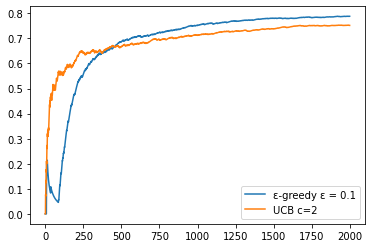

In [12]:
pyplot.plot(avg_rw, label='\u03b5-greedy \u03b5 = %.1f' % ep)
pyplot.plot(ucb_avg_rw, label="UCB c=%i" % c)
pyplot.legend()

f = pyplot.plot()

## Gradient Bandit

* Gradiant Bandit usa uma função $H_t$ aprendida para cada ação
* Quanto maior a preferência por uma ação, mais frequentemente ela será escolhida
* As probabilidades das ações são determiandas de acordo com a distribuição softmax:

\begin{equation}
P[A_t=a]=\frac{e^{(H_t(a))}}{\sum^{k}_{b=1}e^{(H_t(b))}}=\pi_t(a)
\end{equation}

* As preferências de todas as ações são inicializadas para o mesmo valor
* ex: $H_1(a)=0$
* A cada etapa, uma ação $A_t$ é selecionada e resulta em uma recompensa $R_t$<br>Então todas as preferências são atualizadas da seguinte forma:
\begin{equation}
H_{t+1}(A_t)\doteq H_t(A_t) + \alpha(R_t -\bar{R}_t)(1-\pi_t(A_t)), \text{ and }
\\ H_{t+a}(a)\doteq H_t(a) - \alpha(R_t-\bar{R}_t)\pi_t(a), \text{ for all } a\neq A_t
\end{equation}
onde, $\bar{R}_t$ é a média de todas as recompensas recebidas e serve como baseline para julgar se a ação foi positiva ou não

In [13]:
from numpy import exp

def softmax(pi, H):
  '''
  Função auxiliar para atualizar as políticas altomaticamente
  '''
  for a in range(len(pi)):
    pi[a] = exp(H[a])/sum([exp(H[b]) for b in range(len(H))])
  return pi

In [14]:
from numpy.random import choice

optimal_action = bandits.optimal

alpha = 0.1

H = [0 for _ in range(k)]
N = [0 for _ in range(k)]
# policy
pi = [0 for _ in range(k)]
# mean reward
R = 0

optimal_choice = []

i=0
while i < 1000:
  pi = softmax(pi, H)
  A = choice(range(k), p=pi)
  Rt = bandits.play(A)
  R = (sum(N)*R + Rt)/(sum(N)+1)
  N[A] = N[A] + 1
  H[A] = H[A] + alpha*(Rt - R)*(1 - pi[A])
  for a in range(len(H)):
    if (a != A):
      H[a] = H[a] - alpha*(Rt - R)*pi[a]
  optimal_choice.append(int(optimal_action == A))
  i += 1

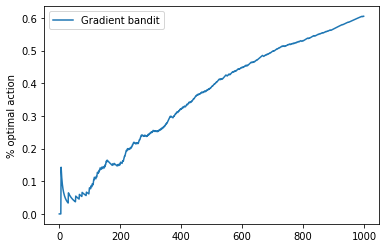

In [15]:
from numpy import cumsum, asarray

opt_choice = cumsum(optimal_choice) / (asarray(range(len(optimal_choice))) + 1)

pyplot.plot(opt_choice, label="Gradient bandit")
pyplot.ylabel("% optimal action")
pyplot.legend()
f = pyplot.plot()

## Associative Search (Contextual Bandit)